# Unsupervised Learning Explorations

This notebook demonstrates common unsupervised learning techniques using the `Iris` dataset and synthetic data.

- Dataset: `Iris` (from scikit-learn) and synthetic `make_blobs` examples
- Techniques: PCA, k-means (elbow method), DBSCAN, t-SNE, and UMAP
- Goals: visualize structure, choose clustering hyperparameters, and compare dimensionality reduction methods

**Notes:**
- Features are scaled with `StandardScaler` before PCA and clustering.
- Adjust `perplexity` (t-SNE) and `n_neighbors` / `min_dist` (UMAP) to explore different layouts.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('default')
sns.set_palette('husl')

In [3]:
from sklearn.datasets import load_iris
iris=load_iris()
X=pd.DataFrame(iris.data, columns=iris.feature_names)
y=iris.target

In [4]:
X.shape

(150, 4)

In [5]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [6]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


PCA is most effective when the features are scaled.
Standard scaler transforms features to have mean=0 and std=1

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [8]:
# Splitting the data
# Stratification is on for labels  to avoid the imbalance, or in other words, 
# to sample enough datapoints from each class
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,random_state=42, stratify=y)
print(X_train.shape)
print(X_test.shape)

(105, 4)
(45, 4)


In [9]:
# Fitting the scaler only on train data
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [10]:
print(X_train.head()),
print(pd.DataFrame(X_train_scaled).head()), 
print(pd.DataFrame(X_test_scaled).head())

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
98                 5.1               2.5                3.0               1.1
68                 6.2               2.2                4.5               1.5
19                 5.1               3.8                1.5               0.3
143                6.8               3.2                5.9               2.3
99                 5.7               2.8                4.1               1.3
          0         1         2         3
0 -0.900459 -1.220248 -0.441986 -0.136610
1  0.380366 -1.879558  0.402829  0.380294
2 -0.900459  1.636764 -1.286801 -1.170419
3  1.078998  0.318143  1.191323  1.414103
4 -0.201827 -0.560937  0.177545  0.121842
          0         1         2         3
0  1.661191 -0.341167  1.416607  0.767972
1  0.263928 -0.341167  0.515471  0.251068
2  0.496805 -0.560937  0.740755  0.380294
3  0.496805  0.537914  0.515471  0.509520
4  0.263928 -0.121397  0.628113  0.767972


# Principal component analysis (PCA)
- Finds maximum variance in the data
- Used for carrying out linear dimensionality reduction, or in other words, to reduce the number of features required to train a machine learning model
- For this particular dataset, we will use PCA to find and plot the first and second principal components that describe the highest extent of variation in the dataset without losing a lot of information
- These two components are orthogonal to each other
- Principal components are useful for visualization, noise reduction, and feature compression
- How original features contribute to each component

In [11]:
from sklearn.decomposition import PCA
pca=PCA(n_components=4) # note: we are choosing 4 components here
X_train_pca=pca.fit_transform(X_train_scaled)
X_test_pca=pca.transform(X_test_scaled)

In [12]:
# explained variance ratio of each of each component
pca.explained_variance_ratio_

array([0.7264421 , 0.23378786, 0.03518741, 0.00458263])

- Check that above the variance is getting lower and lower 
- if we sum first two components we get ~0.96
- which means we can use only first two components and apply ML model without losing much information 

In [13]:
# sum of explained variance ratio
np.sum(pca.explained_variance_ratio_)

0.9999999999999999

But we can also use 'scree plot' to determine how many components to keep.

Text(0.5, 1.0, 'Cumulative variance explained')

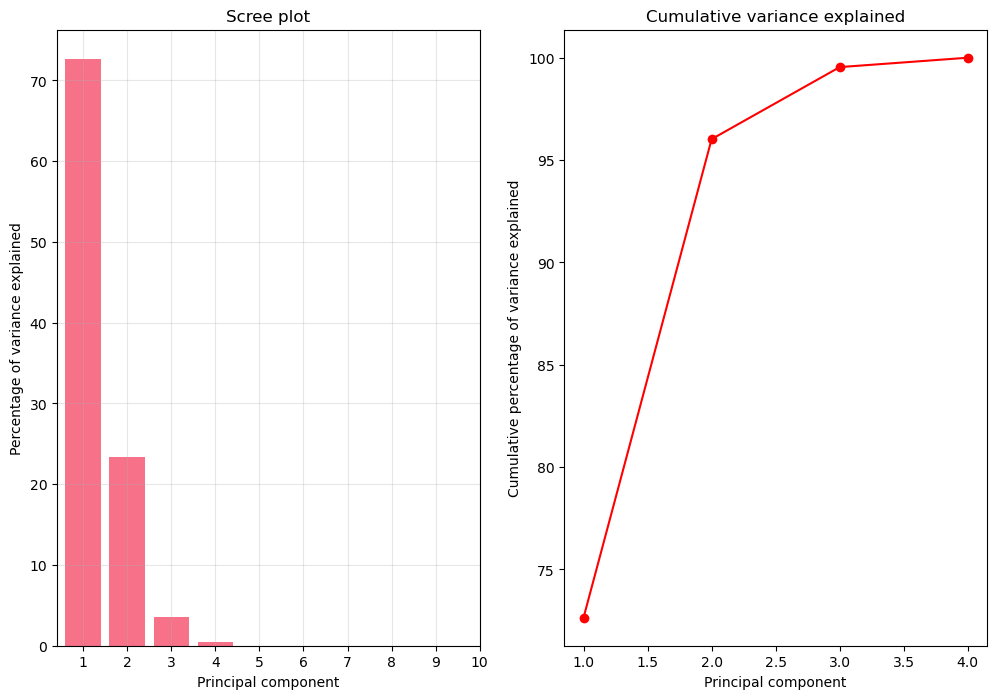

In [14]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.bar(range(1,5),pca.explained_variance_ratio_ * 100)
plt.xlabel('Principal component')
plt.ylabel('Percentage of variance explained')
plt.title('Scree plot')
plt.grid(True, alpha=0.3)
plt.xticks(range(1,11))

plt.subplot(1,2,2)
plt.plot(range(1,5),np.cumsum(pca.explained_variance_ratio_)*100,'ro-')
plt.xlabel('Principal component')
plt.ylabel('Cumulative percentage of variance explained')
plt.title('Cumulative variance explained')

# Scree Plot
- Left plot: Individual variance explained by each component
- Right plot: Cumulative variance explained

Rule of thumb: Keep components until you reach 80-95% cumulative variance, or look for 'elbow' in the scree plot.
In the above figure the elbow is at Principal component number 2

### Applications in engieering and science
- find structure and properties of materials of EV battery or solar cells
- find clusters of the quality of products in the production plants based on operating parameters
- find clusters of molecules in drug making company

# k-means clustering - finding optimal k

Simplest form of clustering in ML. It is used to determine if there are any similarities between certain points in the dataset.

What does it do?
- Divides data into k clusters
- minimizes within-cluster sum of squares (WCSS)
- Intuitively, it results in roughly spherical clusters of similar size because it works on the principle of centroids
- Not suitable for non-spherical or non-convex clusters, so it's better to use another clustering method like DBSCAN

### Elbow Method to decide optimum number of clusters
- plot WCSS vs number of clusters
- Look for 'elbow' where additional clusters don't significantly reduce WCSS
- Balance between model complexity and performance

In [15]:
from sklearn.cluster import KMeans

In [16]:
wcss=[]
k_range=range(1,8)

In [17]:
for k in k_range:
    kmeans=KMeans(n_clusters=k,random_state=20,n_init=10)
    kmeans.fit(X_train_scaled)
    wcss.append(kmeans.inertia_)

c:\Users\suyog\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\suyog\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\suyog\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\suyog\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

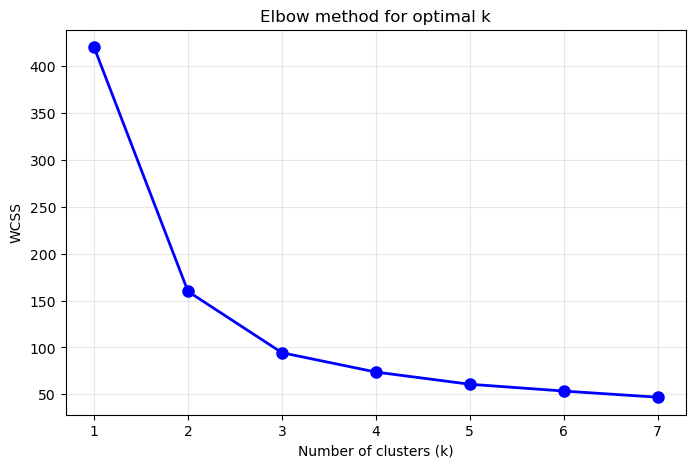

In [18]:
plt.figure(figsize=(8,5))
plt.plot(k_range,wcss,'bo-',linewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow method for optimal k')
plt.grid(True,alpha=0.3)
plt.show()

It can be seen that the 'elbow' is at 3, and we know that there are 3 species of flowers. This is very simple dataset with only 3 classes but when there are hundreds of classes or we don't even know the number of classes. It becomes harder and harder to guess. So, in those real world cases Elbow method is very useful. 

Now based on the elbow plot we choose the k=3 as it appears optimal number of clusters.
Here we will do analysis of following things:
- how many points in each cluster
- the centroid of each cluster

In [19]:
kmeans=KMeans(n_clusters=3,random_state=37, n_init='auto')
train_clusters=kmeans.fit_predict(X_train_scaled)
test_clusters=kmeans.predict(X_test_scaled)

c:\Users\suyog\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [20]:
np.bincount(train_clusters)

array([35, 41, 29], dtype=int64)

In [21]:
np.bincount(test_clusters)

array([15, 18, 12], dtype=int64)

In [22]:
plt.figure(figsize=(12,4))
species_colors=['red','yellow','green']
species_labels=['Setosa','Versicolor','Virginica']
unique_clusters=np.unique(train_clusters)
cluster_colors=['red','yellow','green']

<Figure size 1200x400 with 0 Axes>

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

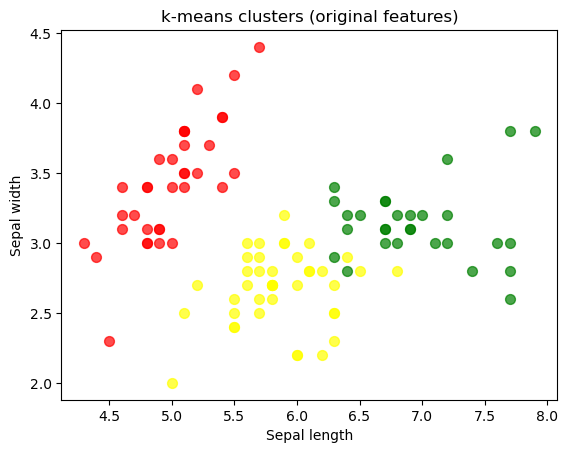

In [23]:
for cluster, color in zip(unique_clusters, cluster_colors):
    plt.scatter(
        X_train.iloc[train_clusters==cluster,0],
        X_train.iloc[train_clusters==cluster,1],
        c=[color],label=f"Cluster {cluster}",alpha=0.7,s=50)

plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('k-means clusters (original features)')
plt.legend


# DBSCAN - density-based clustering

DBSCAN is a density-based spatial clustering of applications with noise
- No need to specify the number of clusters beforehand
- Can find clusters of arbitrary shape (not just spherical)
- Identifies noise points (outliers)
- Density-based: Groups together points in high-density areas

Key parameters:
- eps: maximum distance between two samples to be considered neighbors
- min_samples: Minimum number of samples in a neighborhood to form a cluster

Choosing eps parameter is crucial for DBSCAN:

- k-distance graph: plot distances to k-th nearest neighbor for all points
- Look for the "elbow": sharp increase indicates transition from dense to sparse regions
- eps value: choose the distance at the elbow point

In [24]:
from sklearn.neighbors import NearestNeighbors
k=10
neighbors=NearestNeighbors(n_neighbors=k)
neighbors_fit=neighbors.fit(X_train_scaled)
distances, indices=neighbors_fit.kneighbors(X_train_scaled)

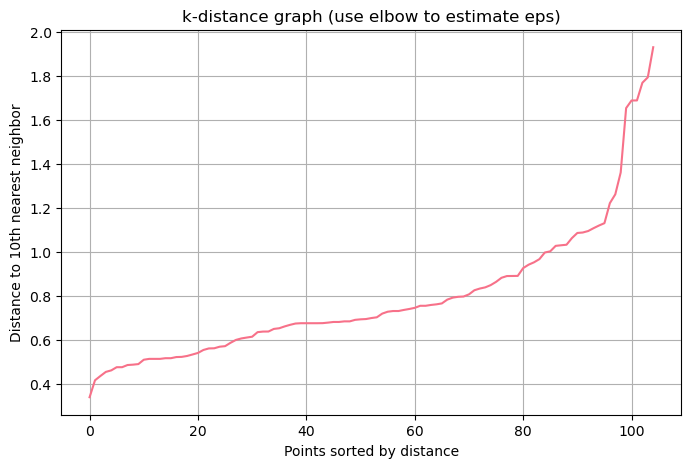

In [25]:
distances=np.sort(distances[:,k-1])
plt.figure(figsize=(8,5))
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance to 10th nearest neighbor")
plt.title("k-distance graph (use elbow to estimate eps)")
plt.grid(True)
plt.show()

From above graph we see that, there is a sharp increase at y value of 1.1 which indicates transition from dense to sparse regions. So we choose eps=1.1 and this value should:
- Capture the main density regions as clusters
- Separate sparse regions as noise
- Balance between too many small clusters and too few large ones

In [26]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=1.1, min_samples=10)
dbscan_clusters = dbscan.fit_predict(X_train_scaled)

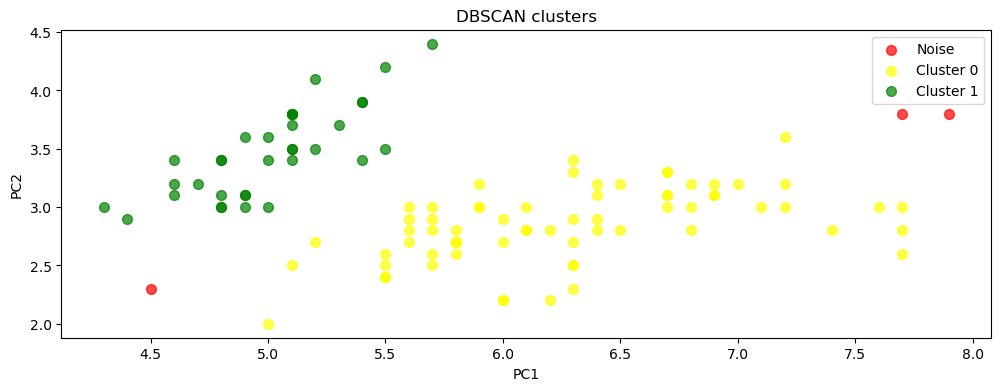

In [27]:
plt.figure(figsize=(12,4))
species_colors=['red','yellow','green']
species_labels=['Setosa','Versicolor','Virginica']
unique_clusters=np.unique(dbscan_clusters)
cluster_colors=['red','yellow','green']


for cluster, color in zip(unique_clusters, cluster_colors):
    label=f"Cluster {cluster}" if cluster != -1 else "Noise"
    plt.scatter(
        X_train.iloc[dbscan_clusters==cluster,0],
        X_train.iloc[dbscan_clusters==cluster,1],
        c=[color],label=label,alpha=0.7,s=50)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('DBSCAN clusters')
plt.legend()

It seems that the DBSCAN is unable to distinguish between two species and hence it has marked all the 2nd and 3rd in same yellow color

### Application of DBSCAN on synthetic data 

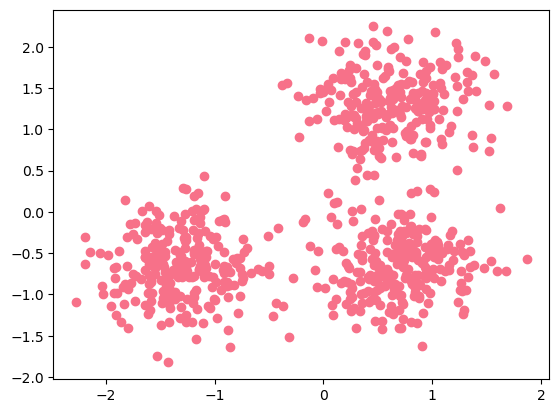

In [28]:
from sklearn.datasets import make_blobs

centers = [[1, 1], [-1, -1], [1, -1]]
X, labels = make_blobs(n_samples=750, centers=centers,cluster_std=0.4, random_state=0)

X=StandardScaler().fit_transform(X)
plt.scatter(X[:, 0], X[:, 1]);

Let's find out similar to above, the eps (epsilon) value using NearestNeighbors method. 
Epsilon is the maximum distance between two points to consider them neighbors.

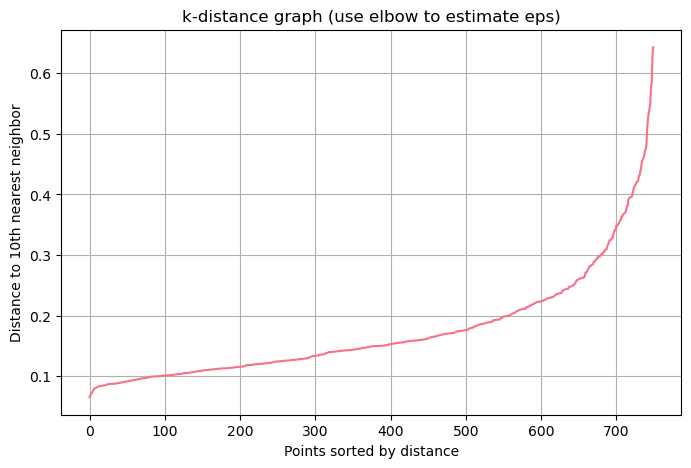

In [29]:
k=10
neighbors=NearestNeighbors(n_neighbors=k)
neighbors_fit=neighbors.fit(X)
distances, indices=neighbors_fit.kneighbors(X)
distances=np.sort(distances[:,k-1])
plt.figure(figsize=(8,5))
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance to 10th nearest neighbor")
plt.title("k-distance graph (use elbow to estimate eps)")
plt.grid(True)
plt.show()

From above plot it seems that the value changes abruptly at around 0.3 approx.

In [30]:
db=DBSCAN(eps=0.3, min_samples=10).fit(X)
labels=db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

Estimated number of clusters: 3
Estimated number of noise points: 18


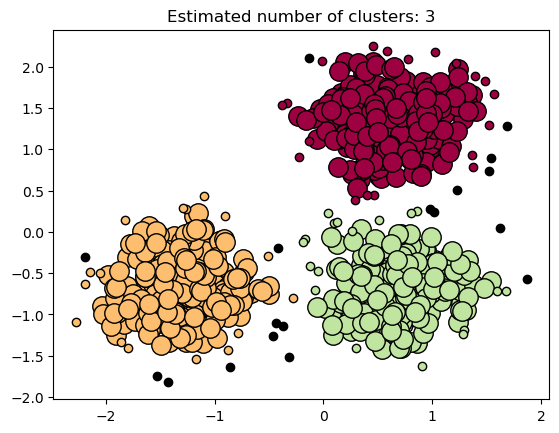

In [31]:
unique_labels=set(labels)
core_samples_mask=np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_]=True

colors=[plt.cm.Spectral(each) for each in np.linspace(0,1,len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=6)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Non-linear dimentionality reduction

### t-SNE (t-distributed stochastic Neighbor Embedding): nonlinear dimentionality reduction

- 
    - This is a powerful technique to visualize high-dimentional data
    - Reduces dimensions while preserving local structure
    - Can capture complex relationships that PCA misses
    - Great for visualization: Especially good at revealing clusters


- Key parameter - perplexity:
    - How many neighbors should each point consider?
    - Low perplexity (5-10): Focuses on very local structure
    - High perplexity (30-50): Considers more global structure
    - Rule of thumb: Try values between 5 and 50

Computing t-SNE with perplexity=5
Computing t-SNE with perplexity=10
Computing t-SNE with perplexity=30
Computing t-SNE with perplexity=50


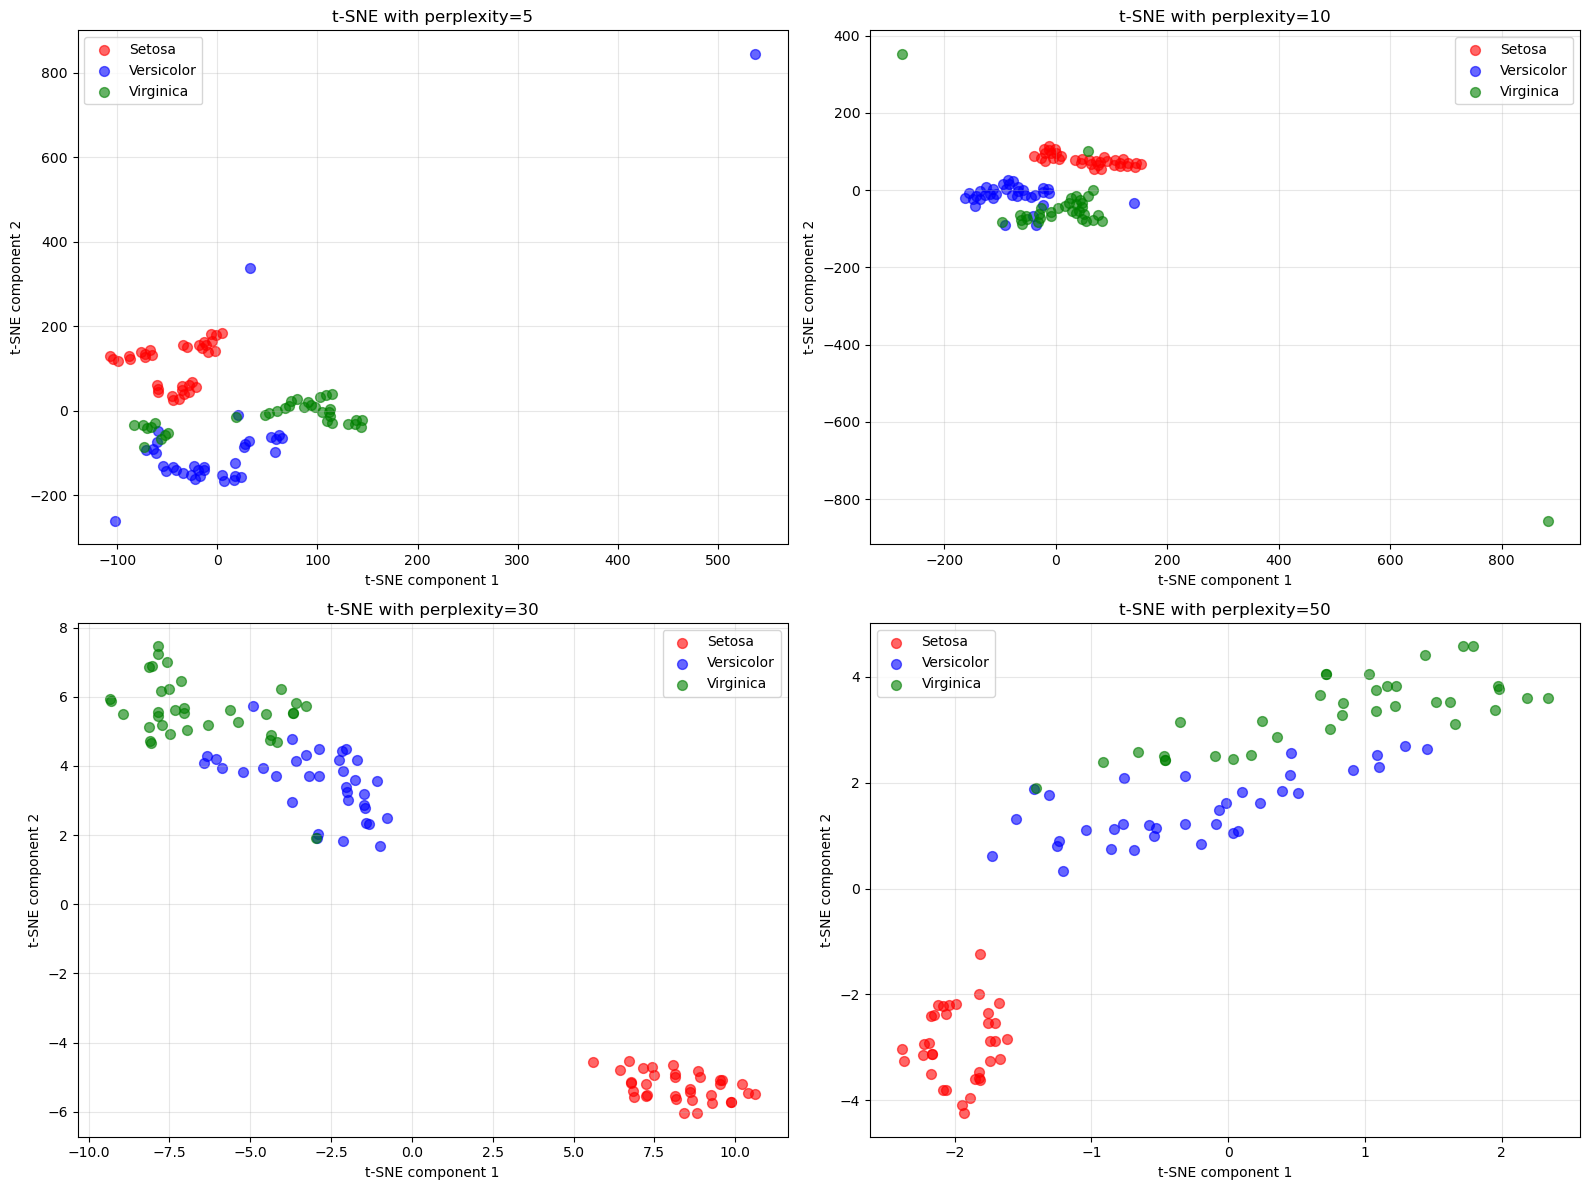

In [34]:
from sklearn.manifold import TSNE

perplexity_values=[5,10,30,50]
plt.figure(figsize=(16,12))

colors=['red','blue','green']
labels=['Setosa','Versicolor','Virginica']

for i, perplexity in enumerate(perplexity_values):
    print(f"Computing t-SNE with perplexity={perplexity}")
    tsne=TSNE(n_components=2, perplexity=perplexity, 
              random_state=42,
              #n_iter=1000,
              learning_rate=200)
    X_tsne=tsne.fit_transform(X_train_scaled)

    plt.subplot(2,2,i+1)
    for cls, color, label in zip(np.unique(y_train), colors, labels):
        plt.scatter(
            X_tsne[y_train==cls,0],
            X_tsne[y_train==cls,1],
            c=color,label=label,alpha=0.6,s=50)
        
    plt.title(f't-SNE with perplexity={perplexity}')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.grid(True, alpha=0.3)
    plt.legend()
plt.tight_layout()


### UMAP(Uniform Manifold Approximation and Projection): Modern Dimentionality Reduction

Advantages of UMAP:
- Faster than t-SNE for large dataset
- Better at preserving global structure
- less senstive to hyperparameters
- works well on large datasets

Key Parameter - n_neighbors:
- Low values (5-15): focuses on local structure, more detailed clusters
- High values (50+): preserve more global structure, broader patterns

Computing UMAP with n_neighbors=5


c:\Users\suyog\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP with n_neighbors=15


c:\Users\suyog\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP with n_neighbors=30


c:\Users\suyog\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP with n_neighbors=50


c:\Users\suyog\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


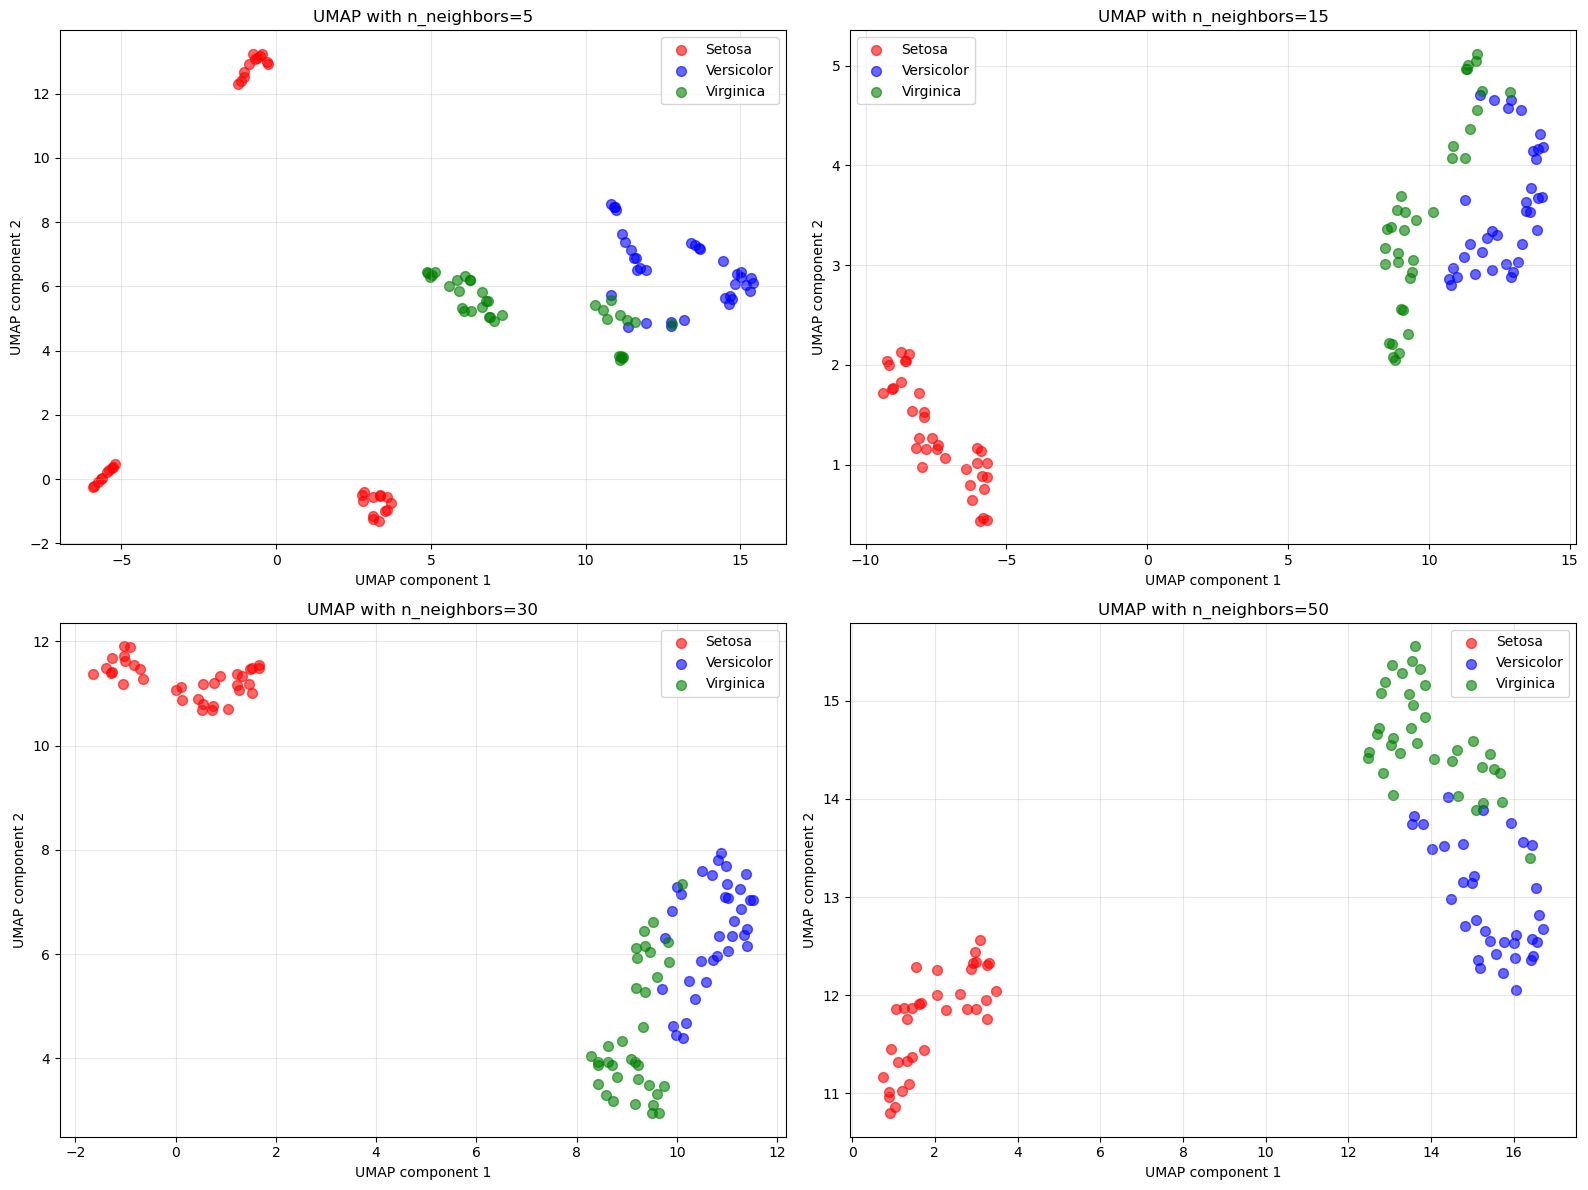

In [36]:
import umap

colors=['red','blue','green']
labels=['Setosa','Versicolor','Virginica'] 
n_neighbors_values=[5,15,30,50]
plt.figure(figsize=(16,12))

for i, n_neighbors in enumerate(n_neighbors_values):
    print(f"Computing UMAP with n_neighbors={n_neighbors}")
    umap_model=umap.UMAP(n_neighbors=n_neighbors, n_components=2, random_state=42,min_dist=0.1,n_jobs=-1)
    X_umap=umap_model.fit_transform(X_train_scaled)

    plt.subplot(2,2,i+1)
    for cls, color, label in zip(np.unique(y_train), colors, labels):
        plt.scatter(
            X_umap[y_train==cls,0],
            X_umap[y_train==cls,1],
            c=color,label=label,alpha=0.6,s=50) 
    plt.title(f'UMAP with n_neighbors={n_neighbors}')
    plt.xlabel('UMAP component 1')
    plt.ylabel('UMAP component 2')
    plt.grid(True, alpha=0.3)
    plt.legend()
plt.tight_layout()
plt.show()